In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
%matplotlib inline

In [5]:
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import callbacks
from tensorflow.keras.initializers import VarianceScaling
from sklearn.cluster import KMeans

In [6]:
df=pd.read_csv(r'C:\Users\m_joekid\Desktop\Movie Success\df_copy.csv') # df_copy is a dataset export from my preprocesing sda

In [7]:
del(df['Unnamed: 0'])  

In [8]:
df_clust=df[['budget','popularity','revenue','runtime','vote_average','vote_count','release_quarter']]

In [9]:
from sklearn.preprocessing import MinMaxScaler
mscaler=MinMaxScaler()

In [10]:
x=df_clust.values

In [11]:
x=mscaler.fit_transform(x)

###  The following function is to create an autoencoder for the DEC algorithm

In [12]:
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected symmetric auto-encoder model.
  
    dims: list of the sizes of layers of encoder like [500, 500, 2000, 10]. 
          dims[0] is input dim, dims[-1] is size of the latent hidden layer.

    act: activation function
    
    return:
        (autoencoder_model, encoder_model): Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    
    input_data = Input(shape=(dims[0],), name='input')
    x = input_data
    
    # internal layers of encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # latent hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)

    x = encoded
    # internal layers of decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # decoder output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    
    decoded = x
    
    autoencoder_model = Model(inputs=input_data, outputs=decoded, name='autoencoder')
    encoder_model     = Model(inputs=input_data, outputs=encoded, name='encoder')
    
    return autoencoder_model, encoder_model

In [13]:
n_clusters = 2
n_epochs   = 100
batch_size = 128

In [14]:
kmeans = KMeans(n_clusters=n_clusters, n_jobs=4)
y_pred_kmeans = kmeans.fit_predict(x)

In [15]:
dims = [x.shape[-1], 500, 500, 2000, 10] 
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(lr=1, momentum=0.9)
pretrain_epochs = n_epochs
batch_size = batch_size
save_dir = 'C:/Users/m_joekid/Desktop/Vscodes'

In [16]:
dims

[7, 500, 500, 2000, 10]

In [17]:
autoencoder, encoder = autoencoder(dims, init=init)

In [18]:
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs)
autoencoder.save_weights(save_dir + '/ae_weights.h5')

Train on 3229 samples
Epoch 1/100
3229/3229 [==============================] - 4s 1ms/sample - loss: 0.0436
Epoch 2/100
3229/3229 [==============================] - 2s 693us/sample - loss: 0.0270
Epoch 3/100
3229/3229 [==============================] - 2s 682us/sample - loss: 0.0284
Epoch 4/100
3229/3229 [==============================] - 2s 706us/sample - loss: 0.0222
Epoch 5/100
3229/3229 [==============================] - 2s 701us/sample - loss: 0.0154
Epoch 6/100
3229/3229 [==============================] - 2s 715us/sample - loss: 0.0363
Epoch 7/100
3229/3229 [==============================] - 2s 713us/sample - loss: 0.0155
Epoch 8/100
3229/3229 [==============================] - 2s 774us/sample - loss: 0.0087
Epoch 9/100
3229/3229 [==============================] - 2s 724us/sample - loss: 0.0070
Epoch 10/100
3229/3229 [==============================] - 2s 734us/sample - loss: 0.0069
Epoch 11/100
3229/3229 [==============================] - 2s 702us/sample - loss: 0.0066
Epoch 12/1

In [19]:
autoencoder.save_weights(save_dir + '/ae_weights.h5')

In [20]:
autoencoder.load_weights(save_dir + '/ae_weights.h5')

### implementing DEC Soft Labeling
One of the key components in the DEC method  is soft labeling, that is, assigning an estimated class to each of the data samples in such a way that it can be refined iteratively. To this end, similarly to a new ClusteringLayer class is defined:

In [21]:
class ClusteringLayer(Layer):
    '''
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with t-distribution.
    '''

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(name='clusters', shape=(self.n_clusters, input_dim), initializer='glorot_uniform') 
        
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        ''' 
        t-distribution, as used in t-SNE algorithm.
        It measures the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
       
        inputs: the variable containing data, shape=(n_samples, n_features)
        
        Return: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        '''
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure all of the values of each sample sum up to 1.
        
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

###  Once the soft labeling layer is defined, it can be used to form a DEC model

In [22]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)

In [23]:
model.compile(optimizer=SGD(0.01, 0.9), loss='kld')

In [24]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))

In [25]:
y_pred_last = np.copy(y_pred)

In [26]:
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

### The DEC model is trained iteratively

In [27]:
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [28]:
loss = 0
index = 0
maxiter = 1000 # 8000
update_interval = 100 # 140
index_array = np.arange(x.shape[0])

In [29]:
tol = 0.001

In [30]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0) # verbose=0 to remove all the noise in the notebook
        p = target_distribution(q)  # update the auxiliary target distribution p

    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/DEC_model_final.h5')

In [31]:
model.load_weights(save_dir + '/DEC_model_final.h5')

### The new DEC model is trained iteratively

In [32]:
# Eval.
q = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)

In [33]:
df_copy=df.copy()

In [34]:
df_copy['cluster']=y_pred

In [35]:
df_copy.sample(2)

,cast,crew,budget,genres,keywords,original_language,original_title,popularity,production_companies,production_countries,revenue,runtime,status,vote_average,vote_count,release_year,release_month,release_quarter,cluster
2858,"['Brian Hooks', ""N'Bushe Wright"", 'Faizon Love']",['DJ Pooh'],6000000,"['Action', 'Comedy', 'Romance']",['sport'],en,3 Strikes,1.433692,[],['United States of America'],9000000,82.0,Released,5.9,15,2000,3,1,0
1690,"['Emile Hirsch', 'Elisha Cuthbert', 'Timothy O...",['Luke Greenfield'],25000000,['Comedy'],"['porn actor', 'pornographic video', 'high sch...",en,The Girl Next Door,39.784026,"['Regency Enterprises', 'Epsilon Motion Pictur...",['United States of America'],30411183,108.0,Released,6.3,824,2004,4,2,0


In [36]:
df_copy['cluster'].value_counts()

1    1816
0    1413
Name: cluster, dtype: int64

### TSNE Dimensional reduction, similar to pca

In [37]:
from sklearn.manifold import TSNE
x_embedded = TSNE(n_components=2).fit_transform(x)
x_embedded.shape

(3229, 2)

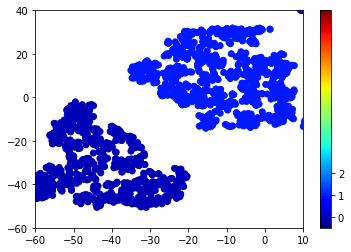

In [62]:
plt.scatter(vis_x, vis_y, c=y_pred_kmeans, cmap=plt.cm.get_cmap("jet", 256))
plt.colorbar(ticks=range(3))
plt.clim(-0.5, 9.5)
plt.xlim(-60,10)
plt.ylim(-60,40)
plt.show()

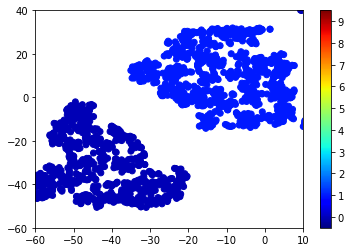

In [63]:
vis_x = x_embedded[:, 0]
vis_y = x_embedded[:, 1]
plt.scatter(vis_x, vis_y, c=y_pred, cmap=plt.cm.get_cmap("jet", 256))
plt.colorbar(ticks=range(256))
plt.clim(-0.5, 9.5)
plt.xlim(-60,10)
plt.ylim(-60,40)
plt.show()

In [41]:
for num_clusters in range(2,10):
    clusterer = KMeans(n_clusters=num_clusters, n_jobs=4)
    preds = clusterer.fit_predict(x)
    # centers = clusterer.cluster_centers_
    score = silhouette_score(x, preds, metric='euclidean')
    print ("For n_clusters = {}, Kmeans silhouette score is {})".format(num_clusters, score))

For n_clusters = 2, Kmeans silhouette score is 0.5079252912233702)
For n_clusters = 3, Kmeans silhouette score is 0.40272161352157443)
For n_clusters = 4, Kmeans silhouette score is 0.43663720515691223)
For n_clusters = 5, Kmeans silhouette score is 0.4531699110683921)
For n_clusters = 6, Kmeans silhouette score is 0.4660734576792246)
For n_clusters = 7, Kmeans silhouette score is 0.39549731014666406)
For n_clusters = 8, Kmeans silhouette score is 0.3476462481347283)
For n_clusters = 9, Kmeans silhouette score is 0.3034964619046413)


## Conclusion
* There is a natural divide as seen from the two distinct clusters formed
* The DCE algorith represents the cluster divide better than kmeans
* Variations are present in both clusters but that is to be expected as some independent studios do well while some big studios end up flopping in the market

In [46]:
x_pca=pca.fit_transform(x)
x_pca.shape

(3229, 2)